<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/rot_2_dim_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install playground-data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

import plygdata as pg

In [3]:
class DigitsDataset(Dataset):
    def __init__(self, transform=None):
        dataset = torch.tensor(pg.dataset.DataGenerator.classify_xor(1000,noise=0.1))
        self.target = dataset[:,2]
        self.data = dataset[:,:2]

        self.transform = transform
        #self.scaler = StandardScaler()
        #self.data = self.scaler.fit_transform(self.data.astype(float))  # Standardize the data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx], self.target[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

# Example usage:
digits_dataset = DigitsDataset()

# Get data and target
data = digits_dataset.data
target = digits_dataset.target

print("Data shape:", data.shape)
print("Target shape:", target.shape)

Data shape: torch.Size([1000, 2])
Target shape: torch.Size([1000])


In [4]:
"""class DigitsDataset(Dataset):
    def __init__(self, transform=None):
        self.data, self.target = load_digits(return_X_y=True)
        self.transform = transform
        self.scaler = StandardScaler()
        self.data = self.scaler.fit_transform(self.data.astype(float))  # Standardize the data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.from_numpy(self.data[idx]).to(torch.float32), self.target[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

# Example usage:
digits_dataset = DigitsDataset()

# Get data and target
data = digits_dataset.data
target = digits_dataset.target

print("Data shape:", data.shape)
print("Target shape:", target.shape)"""

'class DigitsDataset(Dataset):\n    def __init__(self, transform=None):\n        self.data, self.target = load_digits(return_X_y=True)\n        self.transform = transform\n        self.scaler = StandardScaler()\n        self.data = self.scaler.fit_transform(self.data.astype(float))  # Standardize the data\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        sample = torch.from_numpy(self.data[idx]).to(torch.float32), self.target[idx]\n\n        if self.transform:\n            sample = self.transform(sample)\n\n        return sample\n\n# Example usage:\ndigits_dataset = DigitsDataset()\n\n# Get data and target\ndata = digits_dataset.data\ntarget = digits_dataset.target\n\nprint("Data shape:", data.shape)\nprint("Target shape:", target.shape)'

In [5]:
# Define batch size
batch_size = 64

# Create DataLoader
data_loader = DataLoader(digits_dataset, batch_size=batch_size, shuffle=True)

# Example usage:
for batch_idx, (data, target) in enumerate(data_loader):
    print("Batch:", batch_idx)
    print("Data shape:", data.shape)
    print("Target shape:", target.shape)

Batch: 0
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 1
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 2
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 3
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 4
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 5
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 6
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 7
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 8
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 9
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 10
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 11
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 12
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 13
Data shape: torch.Size([64, 2])
Target shape: torch

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()

        # Create a uniform distribution
        self.uni_dist = torch.distributions.uniform.Uniform(0, 1)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)

        angle = self.uni_dist.sample((1,)) * ((2*torch.math.pi)/(1 + torch.exp(encoded))).reshape(-1,1)

        decoded = self.decoder(angle)
        return angle, decoded

# Example usage:
input_dim = 2  # Assuming input images are 28x28 pixels
latent_dim = 1  # Dimensionality of the latent space

# Create an instance of the autoencoder model
model = Autoencoder(input_dim, latent_dim)

# Define loss function (e.g., Mean Squared Error) and optimizer (e.g., Adam)
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
def criterion(x, angle, x_hat):
  loss = 0

  for theta in range(x.shape[0]):
    loss += (torch.matmul(torch.tensor([[torch.cos(angle[theta]), -torch.sin(angle[theta])],
                                [torch.sin(angle[theta]), torch.cos(angle[theta])]]), x[theta].T).T - x_hat[theta])**2
  return loss.mean()

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)

num_epochs = 1000

In [9]:
for epoch in range(num_epochs):
    train_loss = 0.0

    for batch_data, _ in data_loader:

        optimizer.zero_grad()
        angle, reconstructed = model(batch_data)

        loss = criterion(batch_data, angle, reconstructed)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(data_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

<ipython-input-7-2c9b5a78f40d>:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  [torch.sin(angle[theta]), torch.cos(angle[theta])]]), x[theta].T).T - x_hat[theta])**2


Epoch 1/1000, Train Loss: 9.4283
Epoch 2/1000, Train Loss: 9.7548
Epoch 3/1000, Train Loss: 8.3112
Epoch 4/1000, Train Loss: 8.8427
Epoch 5/1000, Train Loss: 8.1434
Epoch 6/1000, Train Loss: 8.6715
Epoch 7/1000, Train Loss: 8.5810
Epoch 8/1000, Train Loss: 7.8039
Epoch 9/1000, Train Loss: 7.8068
Epoch 10/1000, Train Loss: 7.2518
Epoch 11/1000, Train Loss: 8.2631
Epoch 12/1000, Train Loss: 9.2554
Epoch 13/1000, Train Loss: 8.0277
Epoch 14/1000, Train Loss: 8.4691
Epoch 15/1000, Train Loss: 8.6718
Epoch 16/1000, Train Loss: 7.8906
Epoch 17/1000, Train Loss: 8.1584
Epoch 18/1000, Train Loss: 7.9777
Epoch 19/1000, Train Loss: 7.9824
Epoch 20/1000, Train Loss: 7.6514
Epoch 21/1000, Train Loss: 8.1040
Epoch 22/1000, Train Loss: 7.7175
Epoch 23/1000, Train Loss: 8.2938
Epoch 24/1000, Train Loss: 7.8114
Epoch 25/1000, Train Loss: 7.5624
Epoch 26/1000, Train Loss: 8.2277
Epoch 27/1000, Train Loss: 7.8918
Epoch 28/1000, Train Loss: 7.5109
Epoch 29/1000, Train Loss: 8.4893
Epoch 30/1000, Train Lo

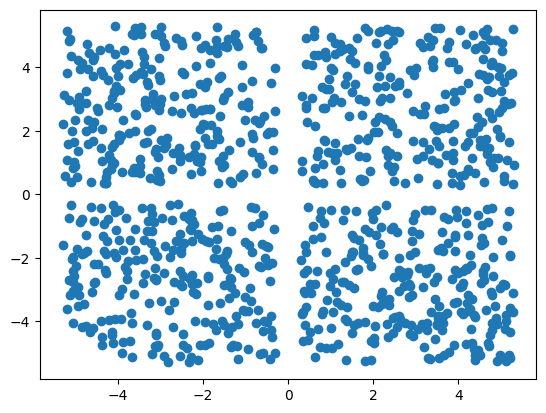

In [10]:
plt.scatter(digits_dataset.data[:,0], digits_dataset.data[:,1])

In [11]:
uniform_dist = torch.distributions.uniform.Uniform(0,1)
sample = uniform_dist.sample((1000,2))* torch.tensor([3, torch.math.pi/2])

In [19]:
a, sonuc = model(digits_dataset.data)

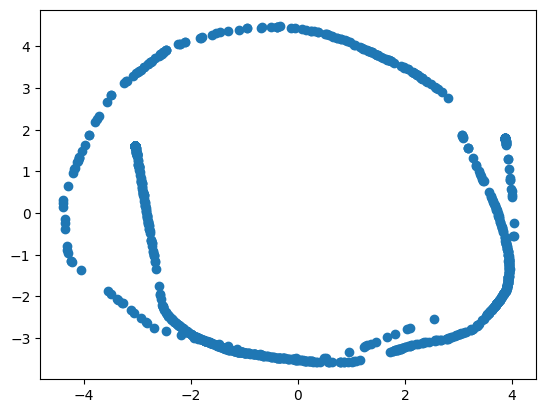

In [20]:
plt.scatter(sonuc[:,0].detach().numpy(), sonuc[:,1].detach().numpy())


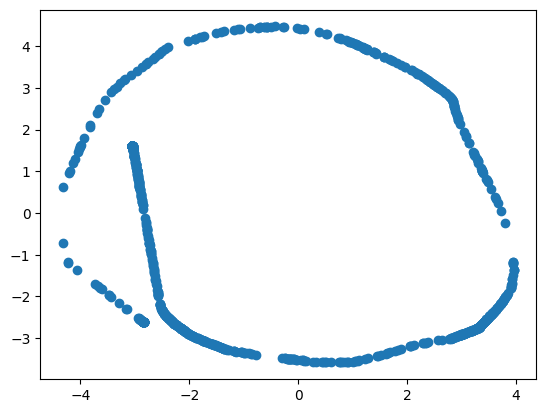

In [14]:
plt.scatter(sonuc[:,0].detach().numpy(), sonuc[:,1].detach().numpy())

In [15]:
s = torch.matmul(torch.tensor([[torch.cos(torch.tensor([torch.pi/3])), -torch.sin(torch.tensor([torch.pi/3]))],
                                [torch.sin(torch.tensor([torch.pi/3])), torch.cos(torch.tensor([torch.pi/3]))]]), digits_dataset.data.T).T

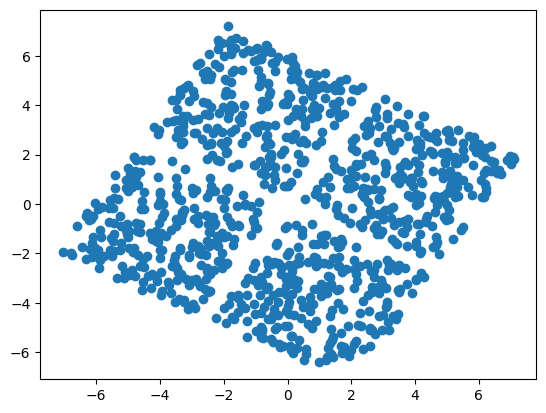

In [16]:
plt.scatter(s.data[:,0].detach().numpy(), s.data[:,1].detach().numpy())

In [17]:
torch.tensor([[torch.cos(torch.tensor([torch.pi/3])), -torch.sin(torch.tensor([torch.pi/3]))],
                                [torch.sin(torch.tensor([torch.pi/3])), torch.cos(torch.tensor([torch.pi/3]))]])

tensor([[ 0.5000, -0.8660],
        [ 0.8660,  0.5000]])

In [18]:
torch.cos(torch.tensor([torch.pi/3]))

tensor([0.5000])